# News Articles Clustering Using Natural Language Processing

**Darshil Desai & Austin Koenig** <br>
**October 2018**

## Overview

This project will dabble in the field of natural language processing as we look to apply clustering algorithms to a dataset of news articles classified by the type of each news article. This project will first represent our dataset in a count vectorized format. Then it will perform hierarchical clustering algorithms as well as K-Means and KNN. Finally, predictions about the classification of new articles will be made. 

Practical use-cases: 
- Automated content output: A model such as this can automate the content generation pipeline for a company such as a news organization. For instance, say that company A has identified that their readers respond more about news relating to AI and drone technology in particular. Therefore, a model can be placed at a stage where editors of the company can simply upload their work into a system where this model will classify it a specific type and send it down the appropriate pipeline. 

- Marketing: A model such as this will help advertising companies determine what kind of advertisements to display on the appropriate news article.

## Data Selection

We begin this project by performing the following: 

1. We will import and view our raw dataset. It is important to note our dataset was in JSON format and we had to convert it into a dataframe before we carried on with our analysis. <br>
   
2. We will then conduct a brief overview of features. There is great benefit to understanding the dataset features in-depth.

### (1) Importing Libraries & Loading Data

In this section, we will import the necessary libraries for this analysis. Furthermore, we will load the data from a JSON file into a Pandas DataFrame.

In [1]:
#We will begin importing the packages required for analysis and prediction
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list, fcluster
from sklearn.neighbors import KNeighborsClassifier
import random
import re
from sklearn.decomposition import PCA
import math

#Natural language processing: Next we import packages to convert the json data from json file and stopwords
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

#Plotting Packages
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#nltk.download('stopwords')

#A glimpse of the original dataset
news_df = pd.read_json('News_Category_Dataset.json', lines=True)

In [2]:
# renaming "THE WORLDPOST" to WORLDPOST
news_df['category'] = news_df['category'].str.replace('THE WORLDPOST', 'WORLDPOST')
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124989 entries, 0 to 124988
Data columns (total 6 columns):
authors              124989 non-null object
category             124989 non-null object
date                 124989 non-null datetime64[ns]
headline             124989 non-null object
link                 124989 non-null object
short_description    124989 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 5.7+ MB


In [3]:
# Lets view all our categories
for x in list(set(news_df['category'])):
    print (x)

POLITICS
SPORTS
SCIENCE
ARTS & CULTURE
MEDIA
GREEN
BLACK VOICES
WOMEN
FIFTY
ENTERTAINMENT
TRAVEL
GOOD NEWS
PARENTS
LATINO VOICES
IMPACT
ARTS
HEALTHY LIVING
RELIGION
CRIME
TASTE
WORLD NEWS
EDUCATION
STYLE
QUEER VOICES
BUSINESS
COLLEGE
COMEDY
TECH
WEIRD NEWS
WORLDPOST


In [4]:
news_df['category'].value_counts(dropna=False).shape

(30,)

### (2) Overview of Features

Our features are as follows:  <br> 
- **Authors:** This feature comprises of the name of authors that have written the article
- **Category:** This feature represents our "y" label when thinking about supervised learning techniques. 
- **Date:** The date on which a specific article was created
- **Headline:** This feature represents the headline or the title of the article. Our model will look into creating a matrix of unique words from this column. This concept is further illustrated below
- **Short Description**: This feature explains what the article is ideally about.Our model will also look into creating a matrix of unique words from this column. This concept is further illustrated below

## Stakeholders

One possible stakeholder could be an advertising company. They would like to know what type of articles are being published on a particluar website or subscription service in order to determine what sort of advertisements to display on those pages. 

Another stakeholder might be a social scientist who is performing a study to see what kinds of things are popular in the modern media.

Another possibility could be news companies themselves who want to determine what their journalists should be writing about to compete with other news organizations.

# Objective

- The objective of our project is to determine a relationship between the types of news articles written in the dataset, and to use such information to make predictions about future news articles.

The objective of our dataset focuses on the following:

- Our dataset will allow us to form clusters of similar articles in our dataset and get a better understanding of the underlying similarities in the articles we have. For example: all articles belonging to the category 'crime' clustering can help us group different types of crime together 

- We will use the KNN algorithm to predict what category a test data (new article) may belong to using this model

# Background Research

This dataset was sourced from Kaggle.com You can refer to the link [here](https://www.kaggle.com/rmisra/news-category-dataset/home). There have been numerous other projects conducted on this dataset including but not limited to: 

- Clasification using neural networks and deeper text preprocessing
- News Classification using HAN
- SpaCy Exploration of Political News Headlines
- Basic Clustering

However we have not yet found a project focusing heavily on clustering such as ours. Given a text dataset such as this one, there are numerous combinations of feature sets one can arrive at based on the manner in which they choose to preprocess their data.

## Preprocessing The Data

- Remove authors, date, link
- We will use the `headline` and `short_description` features to create two new features representing the cleaned version of the columns, called `cl_headline` and `cl_short_desc`. Cleaning the data will be further explained below.

## Data Summary

In [4]:
news_df.describe()

,authors,category,date,headline,link,short_description
count,124989,124989,124989,124989,124989,124989
unique,19250,30,1498,124560,124964,103905
top,,POLITICS,2017-01-27 00:00:00,Sunday Roundup,https://www.huffingtonpost.comhttp://www.mothe...,
freq,14151,32739,100,90,2,19590
first,NaN,NaN,2014-04-18 00:00:00,NaN,NaN,NaN
last,NaN,NaN,2018-05-26 00:00:00,NaN,NaN,NaN


The following observations can be made about this dataset:

- There are 124,989 articles belonging to a myriad of categories in our dataset.
- There are 19250 authors in our dataset, meaning each author has written roughly six articles, on average.
- There are 30 distinct preclassification labels in the dataset.

## Data Cleaning

Before we begin to vectorize our text data and create a matrix of counts we need to discard of words, punctuations and numbers that will not neccessarily be of any significance when trying to classify a piece of text based on the words it comprises. 

Hence, for both the `headlines` column and the `short_description` columns we will:

#### A) Removing redundant textual data

- **Remove all stopwords (and, the, for, then, if...)** <br>
Stopwords are words such as "the", "and", or "for"; they are vital forms of the English language and are used in everyday context. As it turns out, they provide little significance to the substance of the text, so they should be omitted. However words such as "data", "motherboard", or "software", for instance, most commonly appear in the context of discussing technology and therefore can be used as a differentiating factor when trying to classify a piece of text. 

- **Remove all numbers** <br>
Numbers, when considered out of context, do not deliver any particular meaning. Thus, numbers may also be omitted.

- **Remove all punctuations** <br>
Punctuation in isolation derives no particular meaning and hence will be removed, also.

- **Remove unneccesarry spaces** <br>
Since spaces obviously contain no significant context, they will be omitted as well.

- **Remove authors, date, link** <br>

- **Convert to all lowercase** <br>
Using multiple cases in our data will create several unique versions of the same words, thus creating noise in the data.

We will use the `headline` and `short_description` features to create two new features representing the cleaned version of the columns, called `cl_headline` and `cl_short_desc`.


#### B) **Convert categorical data into numerical data** 
Our categorical column is composed of nominal data which suggests that there exists distinct relationships between the different categories. We convert the categories into numerical data so as to allow for our algorithms to make use of the category column

We now begin cleaning our data

#### A.  _Removing redundant textual data_
Below is a function that removes all numbers, punctuation, and unnecessary spaces, returning an all-lowercase version of the input string. Then, we create our two new columns in the `news_df` DataFrame.

Below is a function that removes all numbers, punctuation, and unnecessary spaces, returning an all-lowercase version of the input string. Then, after the stopwords are omitted, we create our two new columns in the `news_df` DataFrame, called `cl_headline` and `cl_short_desc`.

In [5]:
sw = stopwords.words('english') # get list of stopwords

def cleaner(dat):
    # cleaner takes a string and returns a string
    if dat != dat: return "" # check for None value
    dat = dat.lower() # set to all lowercase        
    dat = re.sub(r'[^\w\s]', '', dat) # remove punctuation using regular expression
    dat = re.sub(r'\d+', '', dat) # remove numbers using regular expression
    dat = re.sub(r' +', ' ', dat) # replace all multiple spaces with single spaces
    dat = dat.strip() # remove all leading and trailing whitespaces
    return dat

news_df['cl_headline'] = [cleaner(w) for w in news_df['headline']] # clean headline column
news_df['cl_short_desc'] = [cleaner(w) for w in news_df['short_description']] # clean short_description column

# Filter out stopwords from headlines
news_df['cl_headline'] = news_df['cl_headline'].apply(lambda x: ' '.join([word for word in x.split()
                                                                            if word not in (sw)
                                                                             and word.lower() not in (sw)
                                                                             and word.upper() not in sw
                                                                             and word.title() not in (sw)
                                                                         and len(word) > 3]))

# Filter out stopwords from short_description
news_df['cl_short_desc'] = news_df['cl_short_desc'].apply(lambda x: ' '.join([word for word in x.split()
                                                                            if word not in (sw)
                                                                             and word.lower() not in (sw)
                                                                             and word.upper() not in sw
                                                                             and word.title() not in (sw)
                                                                             and len(word) > 3]))

Below are the new clean `cl_headline` and `cl_short_desc` features.

In [6]:
news_df[['cl_headline', 'cl_short_desc']].head()

,cl_headline,cl_short_desc
0,mass shootings texas last week,left husband killed children another america
1,smith joins diplo nicky world cups official song,course song
2,hugh grant marries first time,actor longtime girlfriend anna eberstein tied ...
3,carrey blasts castrato adam schiff democrats a...,actor gives dems asskicking fighting hard enou...
4,julianna margulies uses donald trump poop bags...,dietland actress said using bags really cathar...


#### B) _Convert categorical data into numerical data_
Unlike supervised learning algorithns, clustering algorithms do not employ the use nor require a y label. However for later parts of our analysis we will require a _y_ label to predict cateogies. Therefore it is vital that we convert the dataset's current categorical column into a numerical represenation.
<br> 

For example: if we were to have 3 nominal categories only say Cat, Dog, Tiger they could be represented as follows: <br> 
- cat : 0
- dog : 1
- Tiger: 2

We will perform this process for 30 different categories.

In [7]:
#Here we create a new column where we represent the categories numerically
news_df['category_num'] = news_df.category.astype("category").cat.codes

# max(news_df['category_num']) # the total number of categories given by the dataset
print ('Total Number of unique categories in our dataset: ', len(list(set(news_df['category_num']))))

Total Number of unique categories in our dataset:  30


## Hierarchical Clustering

This section will perfrom hierarchical clustering in order to determine the optimal number of clusters to use in the K-Means algorithm. First, it will use visual analysis with dendrograms. Then, it will use a method called `fcluster`, which takes a number of clusters and some data and then splits the data into that number of clusters.

Dendrograms give us some particularly useful information in the initial stages of cluster analysis. They show via visualization an optimal number of clusters. What this section will outline is the relationship between sample size and number of clusters. First, since the sample size of 4000 was too large for creating several dendrograms per cell even without plotting them, we must first create a temporary sample size list and create new samples.

### (i) Data Sampling

As it turns out, the number of clusters seems to be affected by the sample size. As a consequence of such an observeation, we have decided to try several different samples of varying sizes (ranging from 50 to 10000 samples) in the following sections. Each sample and corresponding analytical objects will be stored in lists.

We perform different data sampling techniques throughout this project. We have designed our sampling methods based on the clustering method we are focusing on

In [80]:
random.seed(3) # setting the seed
nsamples = 5 # number of different sample sizes
size = np.linspace(start=50, stop=4000, num=nsamples, dtype='int') # create nsamples linearly spaced integers

s_headlines = [] # headline samples
s_short_desc = [] # description samples
for s in size:
    s_headlines.append(random.sample(list(news_df['cl_headline']), s)) # pick headline sample
    s_short_desc.append(random.sample(list(news_df['cl_short_desc']), s)) # pick description sample    

## Text Vectorization

This section will consist of the conversion from text data to numerical data. This will be done using a frequency measurement of each unique word in all of the chosen samples. In other words, we will count the number of times each word is used in a headline or description, and then use that number as a component of a word vector in the position indexed by alphabetical list of all words in a sample. Then, we can use clustering techniques to find relationships between these groups of text vectors.

In [10]:
mdfs_h = [round(len(h) / 100) for h in s_headlines] # min_df tolerance for creating headline vectorizers based on sample
mdfs_d = [round(len(h) / 100) for h in s_short_desc] # min_df tolerance for creating description vectorizers for samples

In [11]:
vectorizers_h = [] # list of vectorizers for each sample of headlines
vectorizers_d = [] # list of vectorizers for each sample of descriptions

hls = [] # list of term-headline matrices for each sample
sds = [] # list of term-description matrices for each sample
hl_dfs = [] # list of word vector dataframes from headlines representing each sample
sd_dfs = [] # list of word vector dataframes from descriptions representing each sample

for i in range(len(size)):
    vectorizers_h.append(CountVectorizer(min_df = mdfs_h[i])) # create headline vectorizer
    vectorizers_d.append(CountVectorizer(min_df = mdfs_d[i])) # create description vectorizer
    
    hls.append(vectorizers_h[i].fit_transform(s_headlines[i])) # feed headline vectorizer headline data
    sds.append(vectorizers_d[i].fit_transform(s_short_desc[i])) # feed description vectorizer description data
    
    hl_dfs.append(pd.DataFrame(hls[i].toarray(), columns = vectorizers_h[i].get_feature_names(), index=s_headlines[i]))
    sd_dfs.append(pd.DataFrame(sds[i].toarray(), columns = vectorizers_d[i].get_feature_names(), index=s_short_desc[i]))


In [12]:
sd_dfs[4].head(1)

,also,back,best,cant,change,could,donald,dont,even,every,...,trump,want,week,white,women,work,world,would,year,years
wahoo,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
[print (hl_dfs[x].shape) for x in range(0,5)]    

(50, 298)
(1037, 42)
(2025, 34)
(3012, 35)
(4000, 31)


[None, None, None, None, None]

The lists called `mdfs_h` and `mdfs_d` are actually very important. The `CountVectorizer` constructor has a parameter, called `min_df`, which dictates the minimum word count for any particular word to be included in the vectorization. We filter the words like this because although we have removed all stopwords, there are still words in this data that do not carry very much meaning. Adding to this, if an article is about crime, but mentions a celebrity name once or twice in the description, for instance, then we do not want that name to carry a lot of weight in the decision whether this article is about crime or entertainment. Thus, it makes sense to vary this value by sample size: if there are few samples, then all words will inherently appear less frequent than in the cases where there are many samples.

Below are the words used in the vectorized article headlines/descriptions for each sample.

In [14]:
# Now lets have a look at some of our new featues which are essentially the unique words in the headline column
colu_names = [vectorizers_h[i].get_feature_names() for i in range(len(size))]
colu_names[1][:15]

['another',
 'best',
 'bill',
 'black',
 'calls',
 'campaign',
 'clinton',
 'could',
 'court',
 'democrats',
 'donald',
 'dont',
 'first',
 'health',
 'hillary']

In [15]:
random.seed(123)
ssize = np.linspace(start=50, stop=1000, num=nsamples, dtype='int') # create nsamples linearly spaced integers

ss_headlines = [] # headline samples
ss_short_desc = [] # description samples
for ss in ssize:
    ss_headlines.append(random.sample(list(news_df['cl_headline']), ss)) # pick headline sample
    ss_short_desc.append(random.sample(list(news_df['cl_short_desc']), ss)) # pick description sample 

hmdfs_h = [round(len(h) / 1000) for h in s_headlines] # min_df tolerance for creating headline vectorizers based on sample
hmdfs_d = [round(len(h) / 1000) for h in s_short_desc] # min_df tolerance for creating description vectorizers for samples

Now, we must create new vectorizers and word count vectors:

In [16]:
hvectorizers_h = [] # list of vectorizers for each sample of headlines
hvectorizers_d = [] # list of vectorizers for each sample of descriptions

hhls = [] # list of term-headline matrices for each sample
hsds = [] # list of term-description matrices for each sample
hhl_dfs = [] # list of word vector dataframes from headlines representing each sample
hsd_dfs = [] # list of word vector dataframes from descriptions representing each sample

for i in range(len(size)):
    hvectorizers_h.append(CountVectorizer(min_df = hmdfs_h[i])) # create headline vectorizer
    hvectorizers_d.append(CountVectorizer(min_df = hmdfs_d[i])) # create description vectorizer
    
    hhls.append(hvectorizers_h[i].fit_transform(ss_headlines[i])) # feed headline vectorizer headline data
    hsds.append(hvectorizers_d[i].fit_transform(ss_short_desc[i])) # feed description vectorizer description data
    
    hhl_dfs.append(pd.DataFrame(hhls[i].toarray(), columns = hvectorizers_h[i].get_feature_names(), index=ss_headlines[i]))
    hsd_dfs.append(pd.DataFrame(hsds[i].toarray(), columns = hvectorizers_d[i].get_feature_names(), index=ss_short_desc[i]))


In [17]:
# hierarchal clustering anaysis

links_h = [] # headline linkages
links_d = [] # description linkages

for i in range(nsamples): # creating the linkages for each sample
    links_h.append(linkage(hhl_dfs[i], 'average'))
    links_d.append(linkage(hsd_dfs[i], 'average'))

The following dendrogram represents a sample of size of 50. Notice how few clusters there are.

SAMPLE SIZE:  50





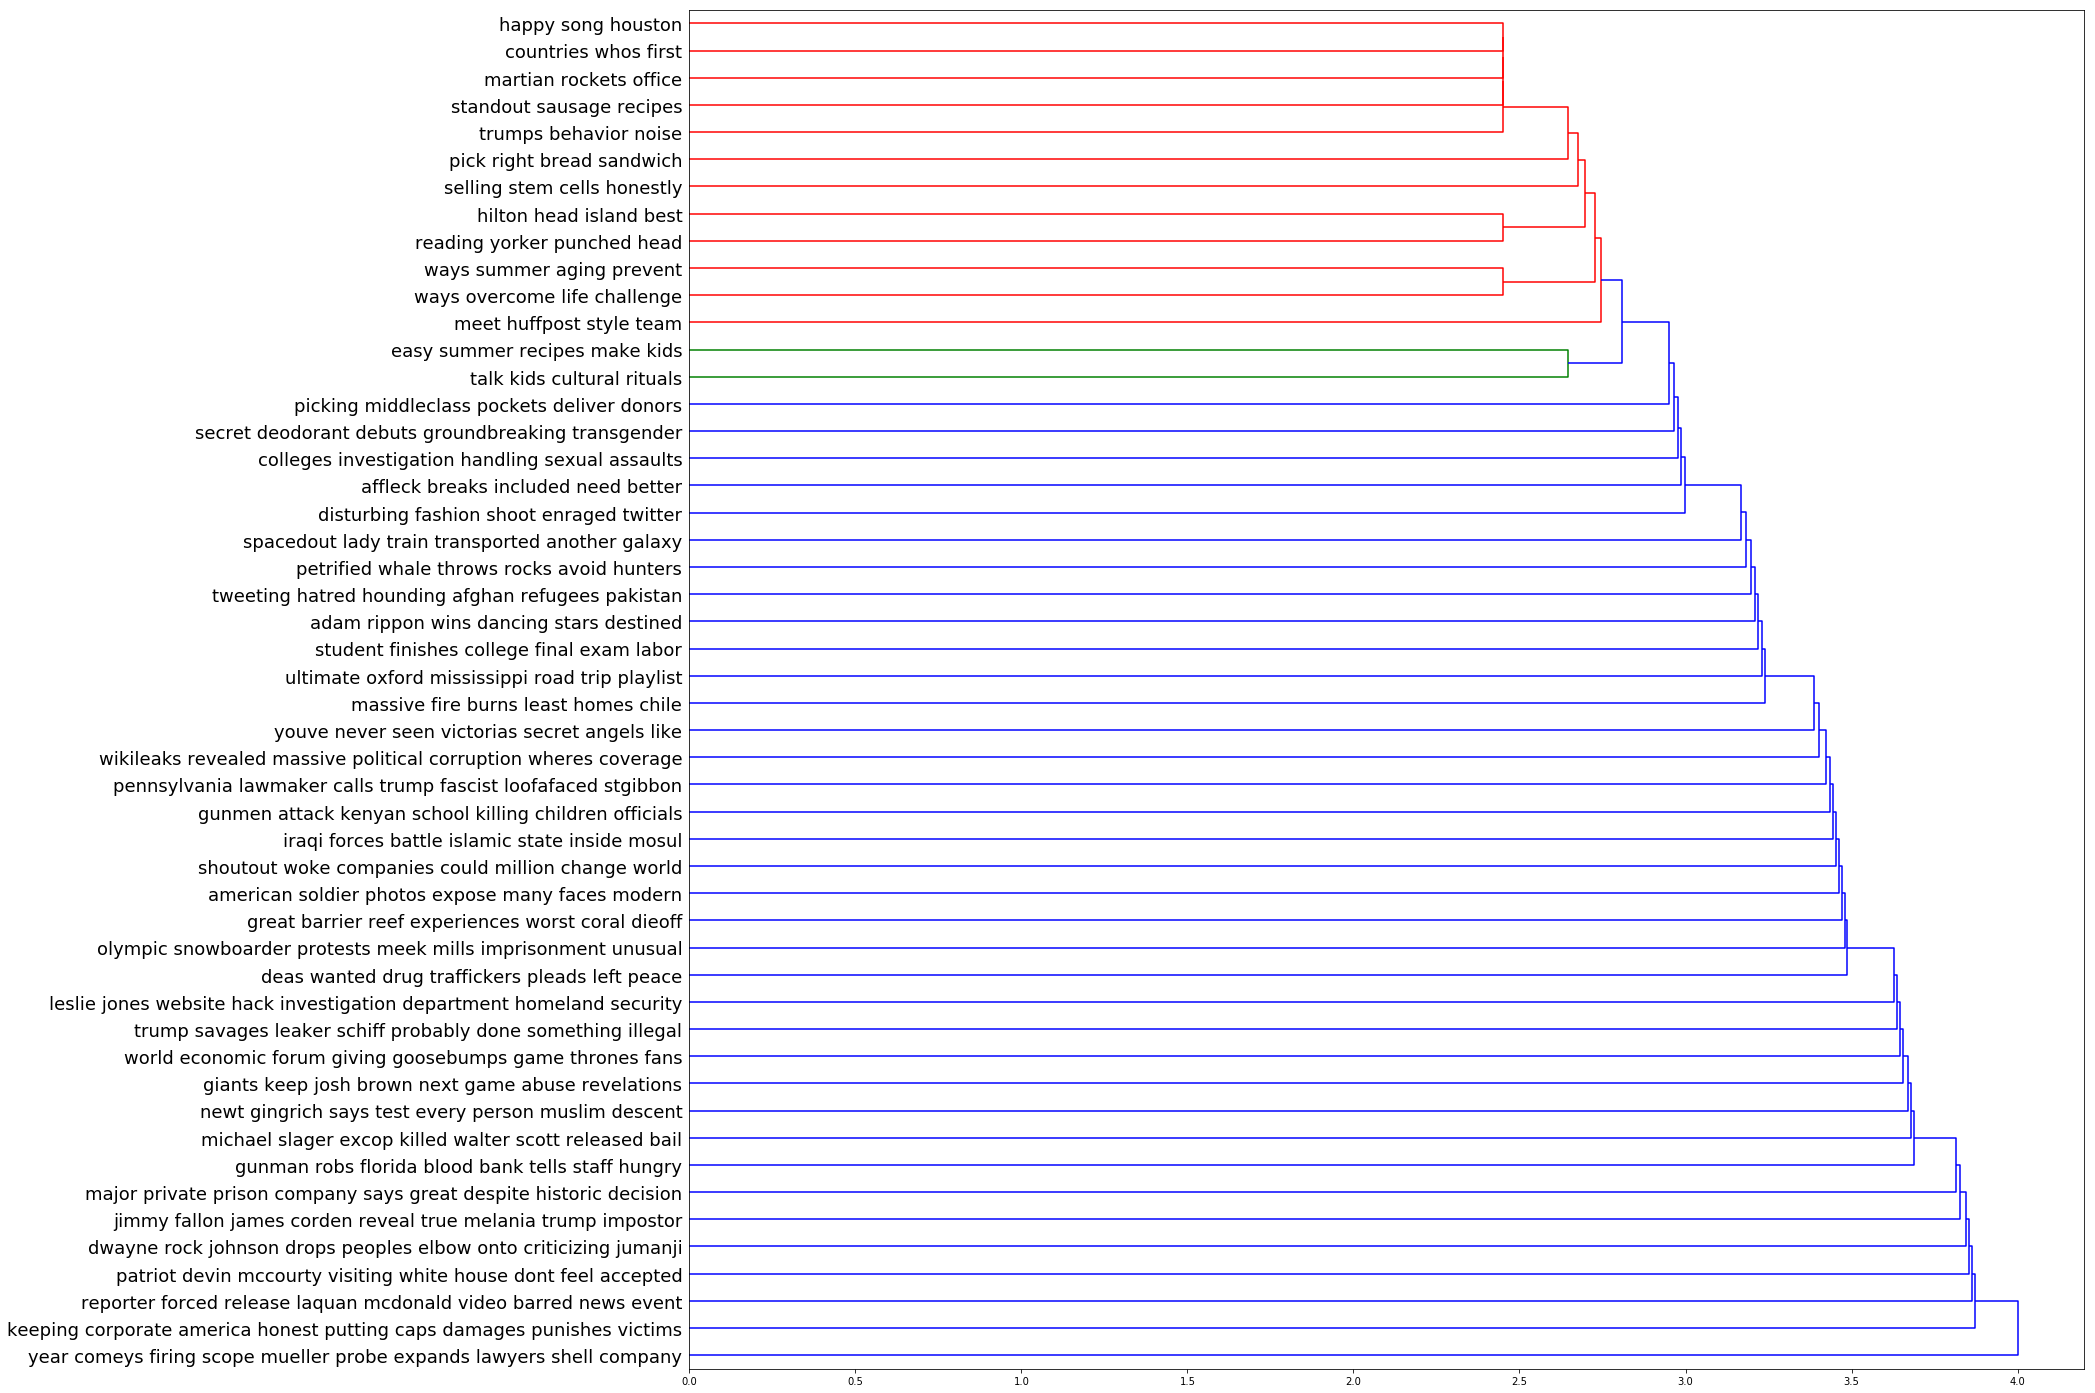

In [18]:
plt.figure(figsize=(25, 25))
print("SAMPLE SIZE: ", size[0])
h1 = dendrogram(Z=links_h[0], orientation="right", leaf_font_size=18, labels=hhl_dfs[0].index)
print('\n\n')

This next dendrogram shows a sample of size 2025. 

SAMPLE SIZE:  2025

 



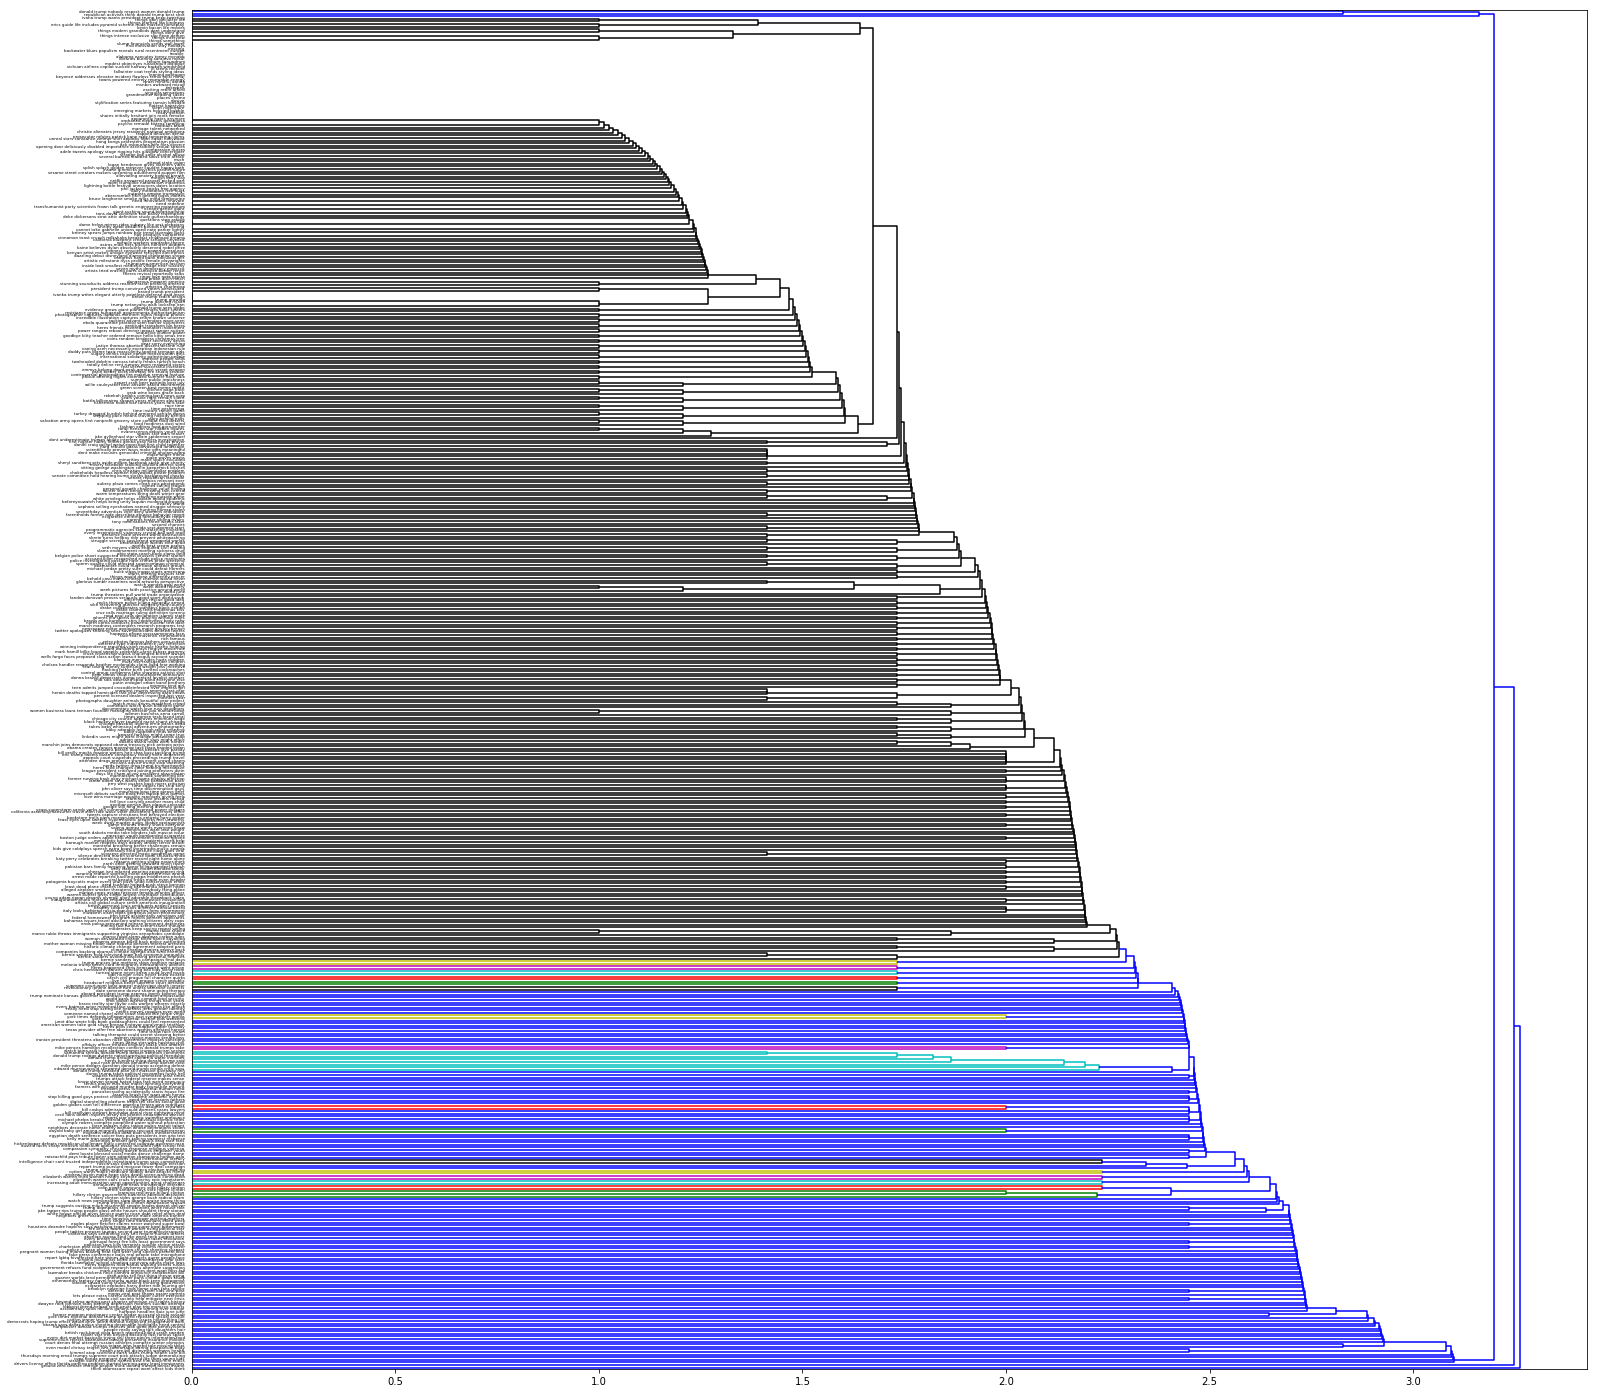

In [19]:
plt.figure(figsize=(25, 25))
print("SAMPLE SIZE: ", size[2])
h2 = dendrogram(Z=links_h[2], orientation="right", leaf_font_size=4, labels=hhl_dfs[2].index)
print ('\n \n')

Let us now observe the same dendrograms for the article descriptions. The following shows a sample size of 50.

SAMPLE SIZE:  50

 



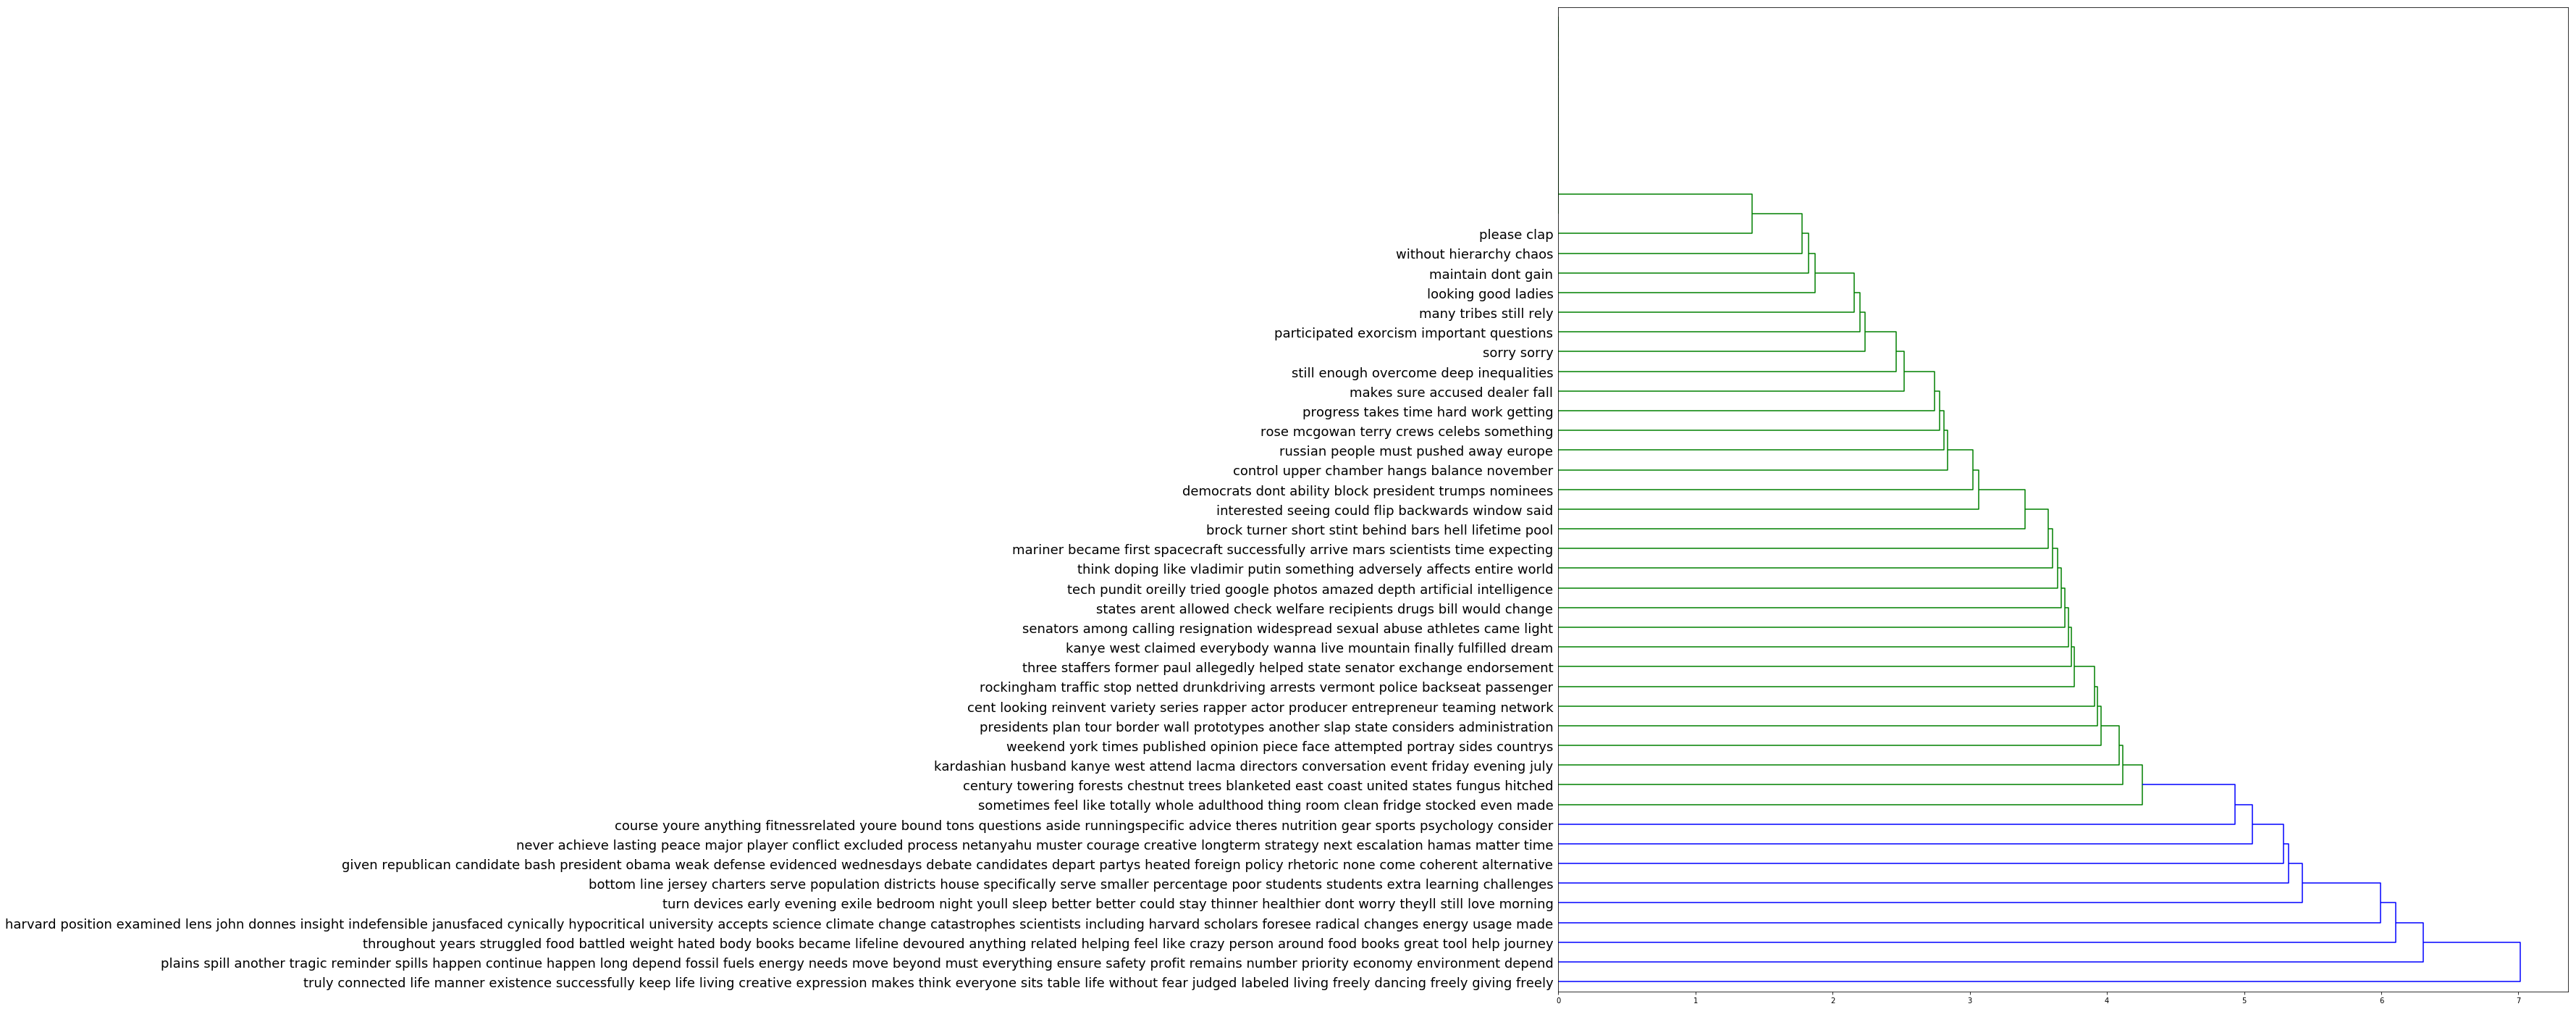

In [20]:
plt.figure(figsize=(25, 25))
print("SAMPLE SIZE: ", size[0])
h2 = dendrogram(Z=links_d[0], orientation="right", leaf_font_size=18, labels=hsd_dfs[0].index)
print ('\n \n')

And now follows the dendrogram for a description sample of size 2025.

SAMPLE SIZE:  2025

 



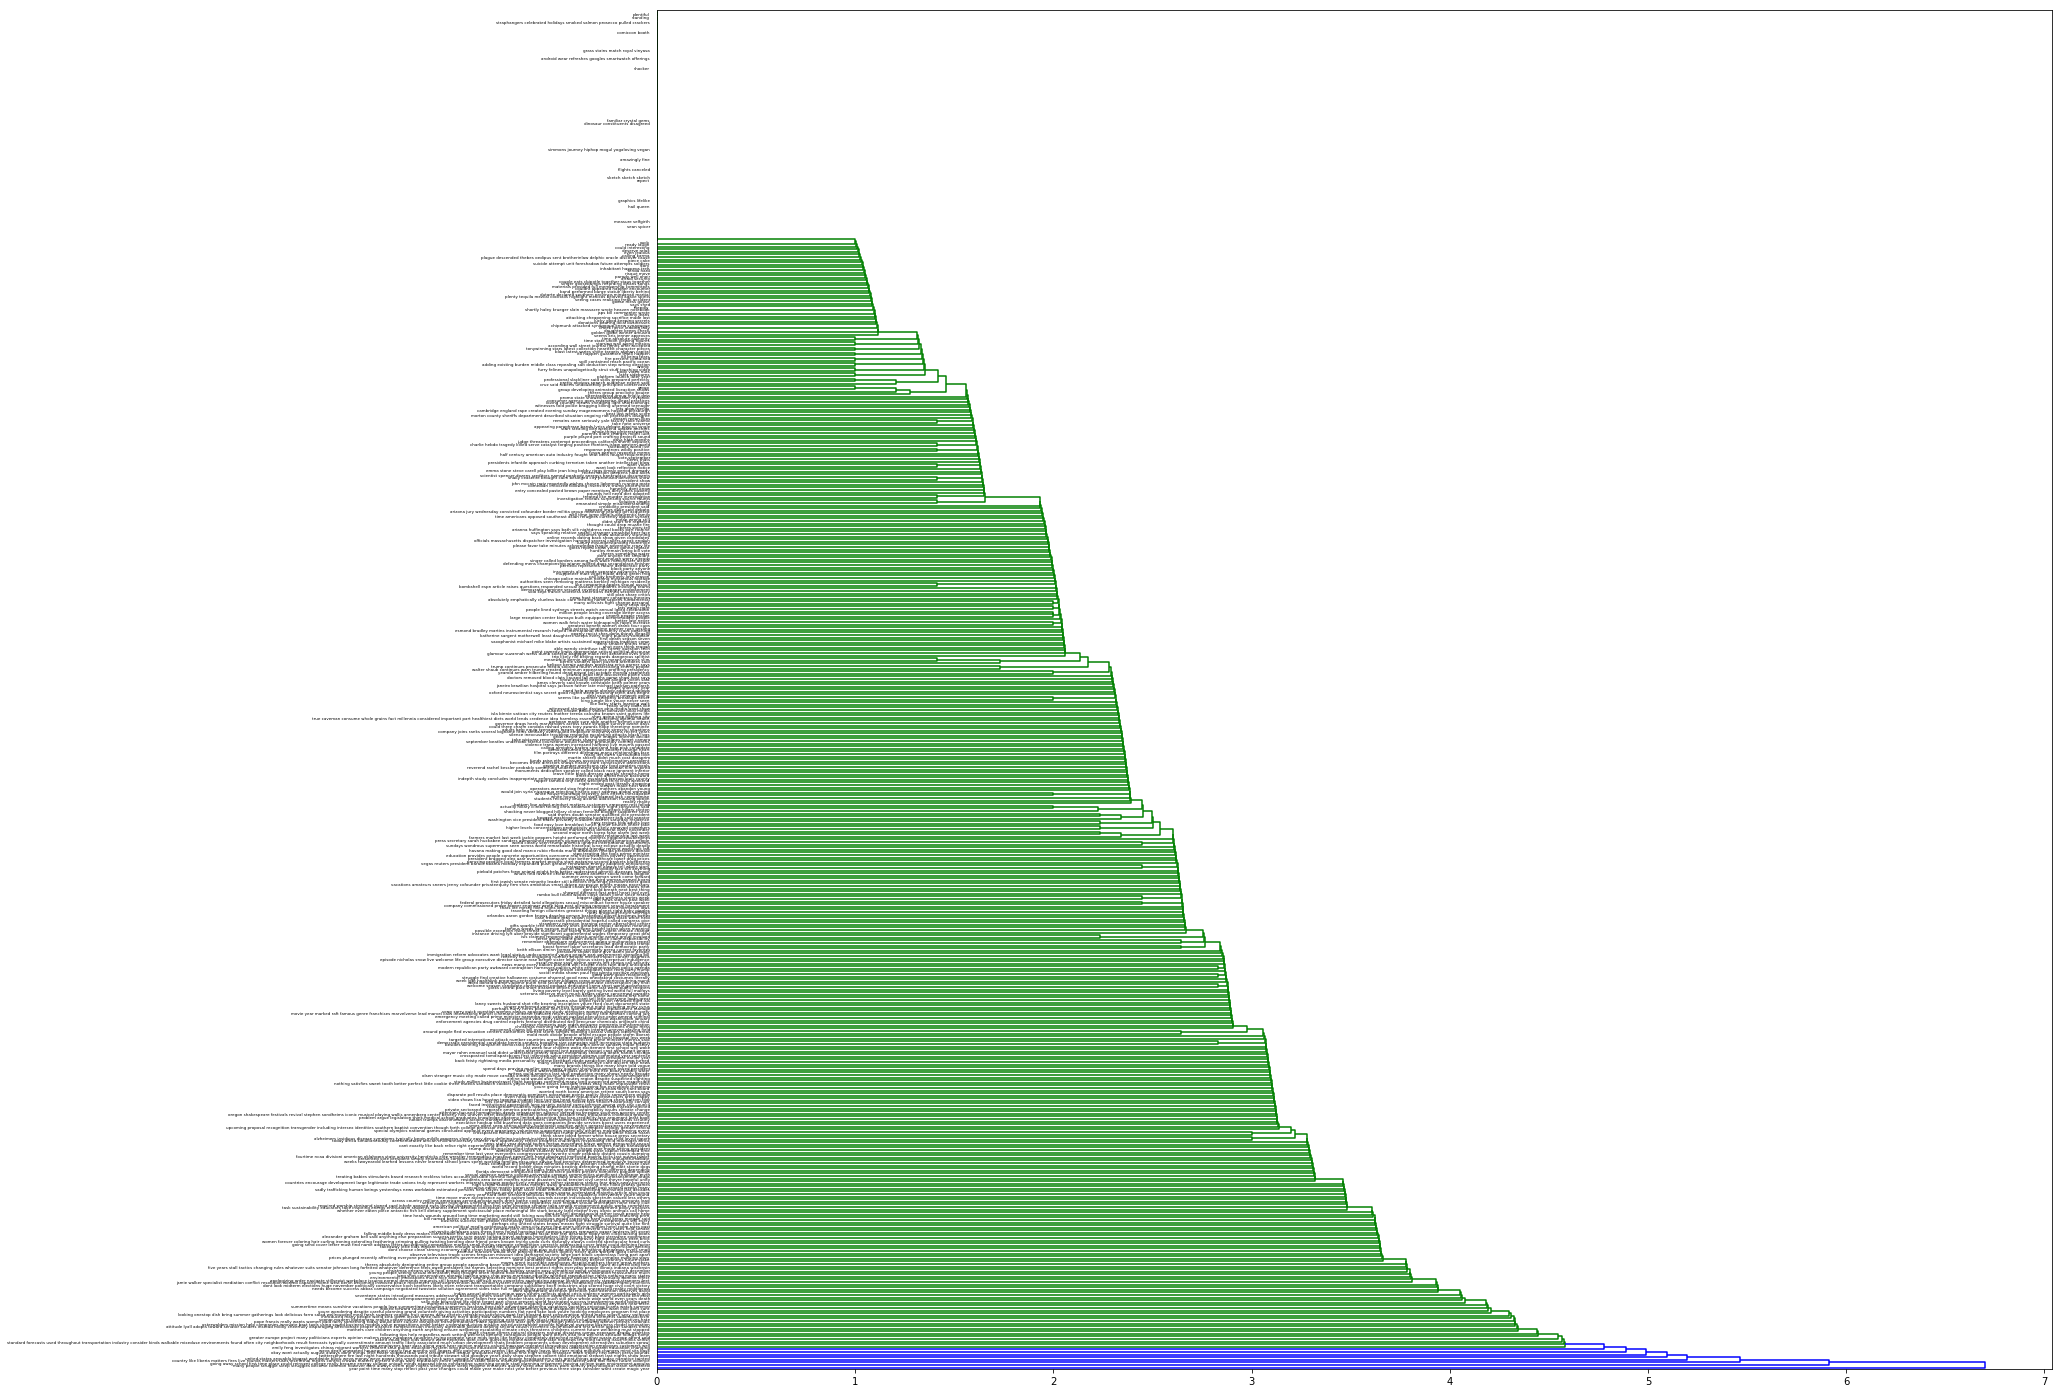

In [21]:
plt.figure(figsize=(25, 25))
print("SAMPLE SIZE: ", size[2])
h2 = dendrogram(Z=links_d[2], orientation="right", leaf_font_size=4, labels=hsd_dfs[2].index)
print ('\n \n')

What the headline dendrograms demonstrate is that as the number of samples increases, the number of clusters also increases. What's interesting is that the article descriptions do not reflect the same phenomenon. However, there must be an optimal number of clusters to use for the K-Means and KNN techniques. Here are the recommended number of clusters for each sample:

In [22]:
dgrams_h = []
dgrams_d = []
for i in range(nsamples):
    dgrams_h.append(dendrogram(Z=links_h[i], no_plot=True, labels=hhl_dfs[i].index))
    dgrams_d.append(dendrogram(Z=links_d[i], no_plot=True, labels=hsd_dfs[i].index))

print("\nHEADLINES SAMPLES & CLUSTERS")
for i in range(nsamples):
    print("SAMPLE SIZE (", size[i], ") CLUSTERS: ", len(set(dgrams_h[i]['color_list'])))

print("\nDESCRIPTIONS SAMPLES & CLUSTERS")
for i in range(nsamples):
    print("SAMPLE SIZE (", size[i], ") CLUSTERS: ", len(set(dgrams_d[i]['color_list'])))


HEADLINES SAMPLES & CLUSTERS
SAMPLE SIZE ( 50 ) CLUSTERS:  3
SAMPLE SIZE ( 1037 ) CLUSTERS:  6
SAMPLE SIZE ( 2025 ) CLUSTERS:  7
SAMPLE SIZE ( 3012 ) CLUSTERS:  5
SAMPLE SIZE ( 4000 ) CLUSTERS:  3

DESCRIPTIONS SAMPLES & CLUSTERS
SAMPLE SIZE ( 50 ) CLUSTERS:  2
SAMPLE SIZE ( 1037 ) CLUSTERS:  2
SAMPLE SIZE ( 2025 ) CLUSTERS:  2
SAMPLE SIZE ( 3012 ) CLUSTERS:  2
SAMPLE SIZE ( 4000 ) CLUSTERS:  2


Finally, we can examine the `fcluster` function, which splits up the input data into the number of clusters we have found to be "optimal". Thus, we can test a range of different numbers of clusters. Let us now use this function to look at each of the headline/description clusters using the second largest sample size, for instance:

In [23]:
opt_clust = [2, 3, 4, 5, 6, 7, 8]
for c in opt_clust:
    clusters_h = fcluster(links_h[3], c, criterion='maxclust')
    clusters_d = fcluster(links_d[3], c, criterion='maxclust')
    print("\n NUMBER CLUSTERS: ", c, "\n")
    print("\nHEADLINES: \n")
    for i in range(c):
        print("CLUSTER ", i, ": ")
        print(hhl_dfs[3].index[clusters_h == i])
    
    print("\nDESCRIPTIONS: \n")
    for i in range(c):
        print("CLUSTER ", i, ": ")
        print(hsd_dfs[3].index[clusters_h == i])


 NUMBER CLUSTERS:  2 


HEADLINES: 

CLUSTER  0 : 
Index([], dtype='object')
CLUSTER  1 : 
Index(['death penalty mercy dear governors spare pardon',
       'nate parker receive sundance institutes vanguard award',
       'marched mother women like', 'squeezing water rock',
       'jerusalem artichoke sunchoke fugly vegetable eating',
       'larry wilmore drops nword national television',
       'iwillprotectyou service members promise terrified muslim girl',
       'today journalists', 'house republicans working plan help puerto rico',
       'report vice journalists released jail turkey',
       ...
       'iggy azalea done nothing life', 'larry scanlon progressive battler',
       'broadway diva defends marriage equality powerful song',
       'years miller alabama looking states justice',
       'trump voters media enemy',
       'nancy pelosi republicans want punish dems sitin make',
       'bernie sanders donald trump right pharma',
       'movie review kingsman secret service b

Looking at the clusters after each run of `fcluster` using a different cluster size, we can see how many clusters may seem optimal by intuition. The clusters seemed more full with 6-8 different clusters, which further solidifies the notion that there are approximately seven clusters in our data.

# K-Means Clustering
- The K-Means clustering algorithm focuses on using the centroid approach whilst trying to determine clusters. 
- It is important to note that here we perform dimension reduction through Princial Component Analysis so as to visually represent our data through plotting

We proceed here as follows:
-  (i) Write a function that will convert a uniform dataset of x samples into a dataframe comprising 2 their principal components
- (ii) Visualize our dataset through using the principal components of different sample sizes
- (iii) Next we select our clusters and for different sample sizes visualize them 
- (iv) Analysis

### (i) Data Sampling & Principal Component Analysis

In order to visualize our K-Means clustering algorithms there lies a neccessity to reduce the dimension of our data since human beings cannot visualize more than 3 dimensions. Therefore PCA helps us project our existing data onto the at least 2 principal components so as to represent our data in 2D. 

In [9]:
"""
Here we write a function that allows us to convert a dataset of any sample size into one 
that is represented by 2 principal components
"""

def plot_pca(sample, column):

    #--------Defining and subsetting our dataet ------------
    #we define our dataframe
    temp_df = news_df   
    #choose random indices to index the news_df dataset by
    rands = (random.sample(list(temp_df.index),int(sample)))  

    #Here we randomly select our dataset based on the sample size mentioned
    temp_df = temp_df.loc[rands]                    
    
    #--------------- Count Vectorizing-----------------
    
    #Initializing a count vectorizing object    
        #note that we set the minimum word count to 3for all sample sizes. All words having a frewuency count 
        #....below the threshold will be removed
    vectorizer = CountVectorizer(min_df=3)  

    #priving the data on which the word frequency count will be conducted
    data_corpus = list(set(temp_df[column]))

    #fitting our data
    X = vectorizer.fit_transform(data_corpus) 
    
    #next we convert our count vectorized object into an mxn dataframe where: 
        # m: number of samples
        #n : number of features or number of unique words from the data corpus after the min count threshold
    tt_df = pd.DataFrame(X.toarray(), columns =vectorizer.get_feature_names() )
    #print (tt_df.shape)

    #----------------------PCA-------------------------
    #Now using our tt_df dataset which comprises our mxn word count data we will project this data onto their 2
    #..principal components

    #we select 2 since we want to visualize in 2D 
    pca = PCA(n_components=2)

    #fitting the dataset
    principalComponents = pca.fit_transform(tt_df)    
    
    #creating an mxb dataframe from the principalComponents object where: 
        #m : number of samples
        #b: principal compoents
    pca_df = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])
    
#     print ('Size of Dataframe : ', pca_df.shape)

    #Now we plot the 2 principal components
    plt.plot(pca_df['principal component 1'], pca_df['principal component 2'], '.')    
    plt.title('Number of samples {}: '.format(sample))
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

### (ii) Visualize our dataset through using the principal components of different sample sizes

As we scale our random sampling sizes, we continously see observe the following: 
- an increase in the number of clusters 
- a growth in the size of most existing clusters

#### Visualizing the title column

Here we plot our datasets into sample sizes specified at the beginning of the report

<Figure size 432x288 with 0 Axes>

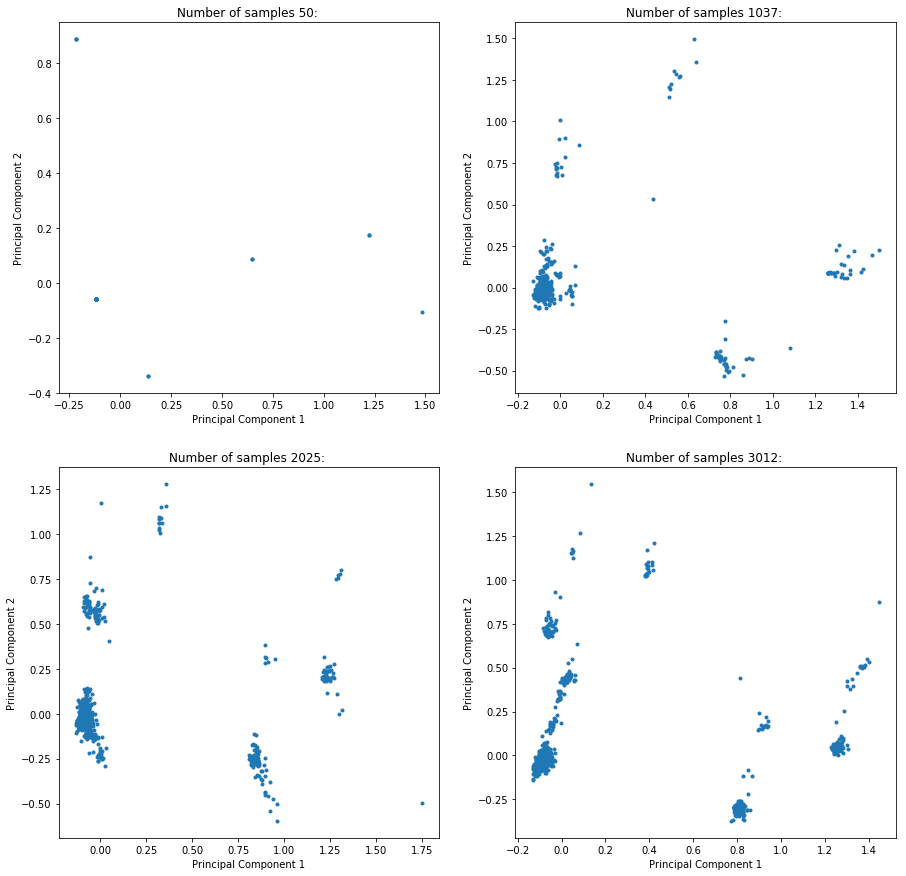

In [12]:
sample_count = size
fig = plt.figure()
plt.figure(figsize=(15,15))
for i,f in zip(range(1, 5),sample_count):    
    plt.subplot(2, 2, i)
    plot_pca(f,'cl_headline')

Here we double our sizes and observe that the following: 
- An increase in the number of clusters formed
- A gradual increase in the size of the existing clusters formed

<Figure size 432x288 with 0 Axes>

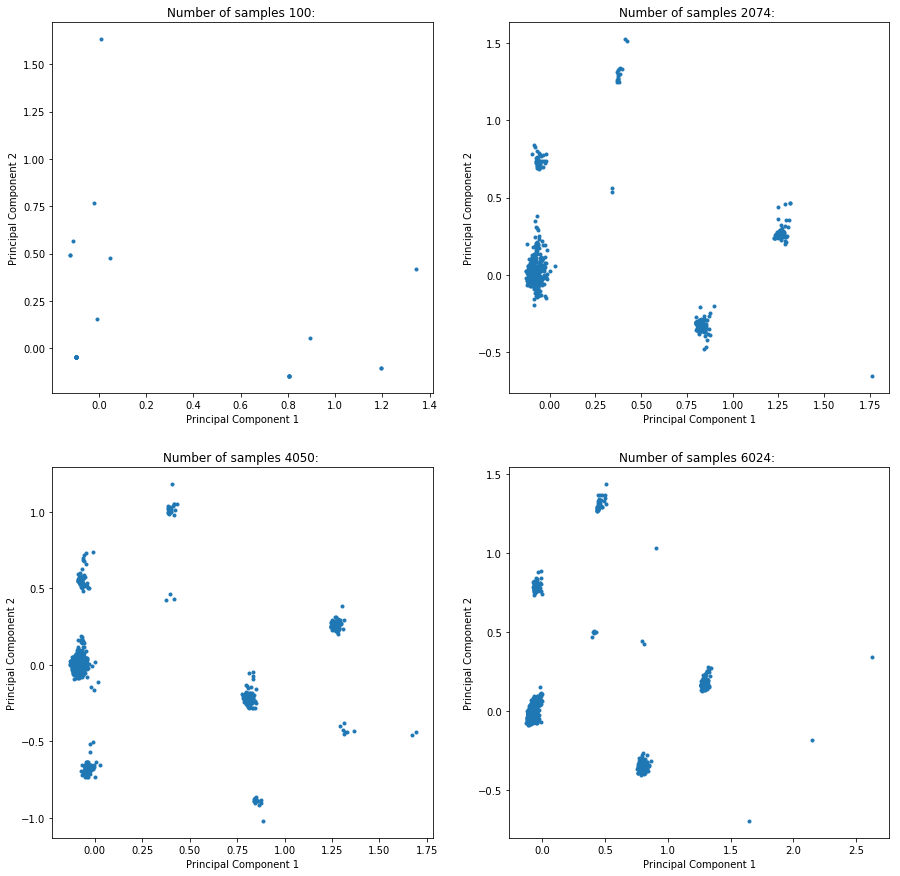

In [13]:
sample_count = size*2
fig = plt.figure()
plt.figure(figsize=(15,15))
for i,f in zip(range(1, 5),sample_count):    
    plt.subplot(2, 2, i)
    plot_pca(f,'cl_headline')

#### Visualizing our short description column

<Figure size 432x288 with 0 Axes>

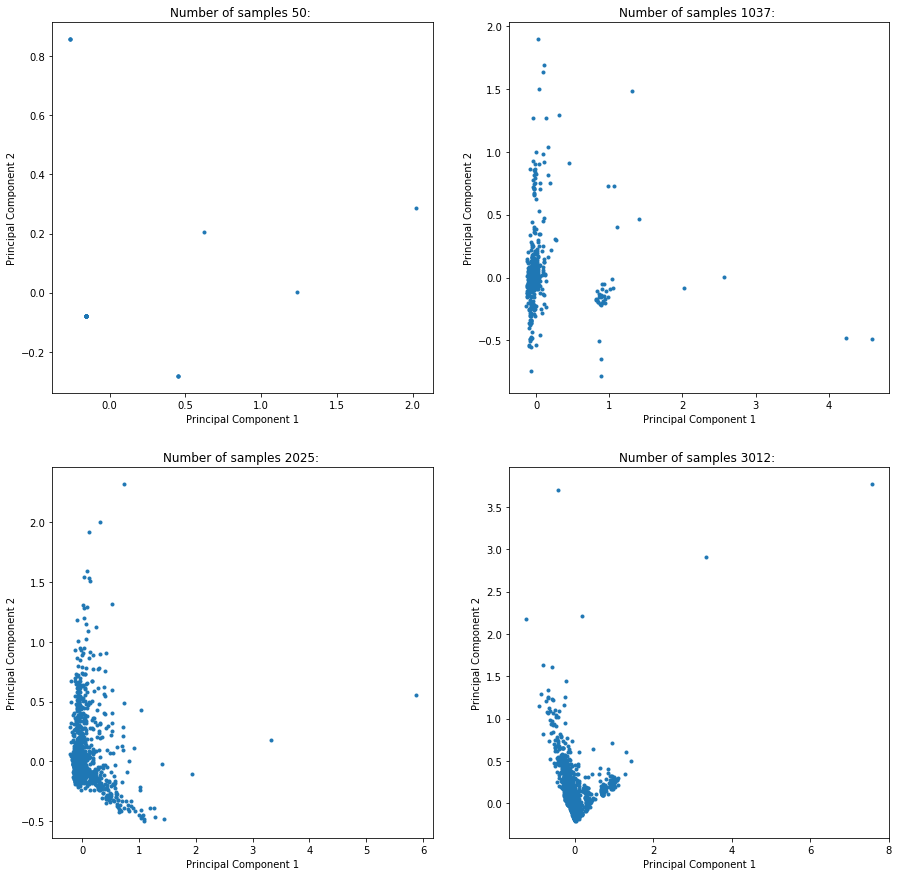

In [14]:
"""
Here we plot our dataset from the short description column and observe very different results
"""

sample_count = size
fig = plt.figure()
plt.figure(figsize=(15,15))
for i,f in zip(range(1, 5),sample_count):    
    plt.subplot(2, 2, i)
    plot_pca(f,'cl_short_desc')

### (iii) Next we will select our clusters and plot them for every different sample sizes

Now that we've visualized our dataset we can see that there exist for the given sample sizes we've chosen and their multiples, formation of several clusters

Next we will conduct the following perform a K-Means analysis and plot the resultant dataset

In [15]:
"""
We begin our K-Means analysis by defining a function that will do the following: 
- for any given dataset project the dataset onto their 2 principal components based on the sample size
- Using the number of clusters provided to perform KMeans analysis
- Plot the KMeans clusters
"""

def plot_modelclusters(sample_size, num_clusters, column):
    
    #--------Defining and subsetting our dataet ------------
    
    #we define our dataframe
    temp_df = news_df 
    
    #choose random indices to index the news_df dataset by
    rands = (random.sample(list(temp_df.index),int(sample_size)))

    #Here we randomly select our dataset based on the sample size mentioned
    temp_df = temp_df.loc[rands]  
     
    #--------------- Count Vectorizing-----------------
    
    #Initializing a count vectorizing object    
        #note that we set the minimum word count to 3 for all sample sizes. All words having a frewuency count 
        #....below the threshold will be removed    
    vectorizer = CountVectorizer(min_df=3)

    #priving the data on which the word frequency count will be conducted
    data_corpus = list(set(temp_df[column]))

    #fitting our data
    X = vectorizer.fit_transform(data_corpus)
    
    #next we convert our count vectorized object into an mxn dataframe where: 
    # m: number of samples
    #n : number of features or number of unique words from the data corpus after the min count threshold
    tt_df = pd.DataFrame(X.toarray(), columns =vectorizer.get_feature_names() )
    #print (tt_df.shape)
    
    #----------------------PCA-------------------------
    
    #Now using our tt_df dataset which comprises our mxn word count data we will project this data onto their 2
    #..principal components

    #we select 2 since we want to visualize in 2D 
    pca = PCA(n_components=2)

    #fitting the dataset
    principalComponents = pca.fit_transform(tt_df)    
    
    #creating an mxb dataframe from the principalComponents object where: 
        #m : number of samples
        #b: principal compoents
    pca_df = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])        
    
    #Fit our model
    kmeans_model = KMeans(n_clusters = num_clusters)  #number of categories
    kmeans_model.fit(pca_df[['principal component 1', 'principal component 2']])
    
        #create a colormap
    colormap = np.array(['green', 'red', 'blue','pink', 'orange', 'black', 'magenta','cyan'])

        #scatter plot
    plt.scatter(pca_df['principal component 1'], pca_df['principal component 2'], c = colormap[kmeans_model.labels_], s=80)
    plt.title('Number of samples {}: '.format(sample_size))

#### Visualizing the title column

<Figure size 432x288 with 0 Axes>

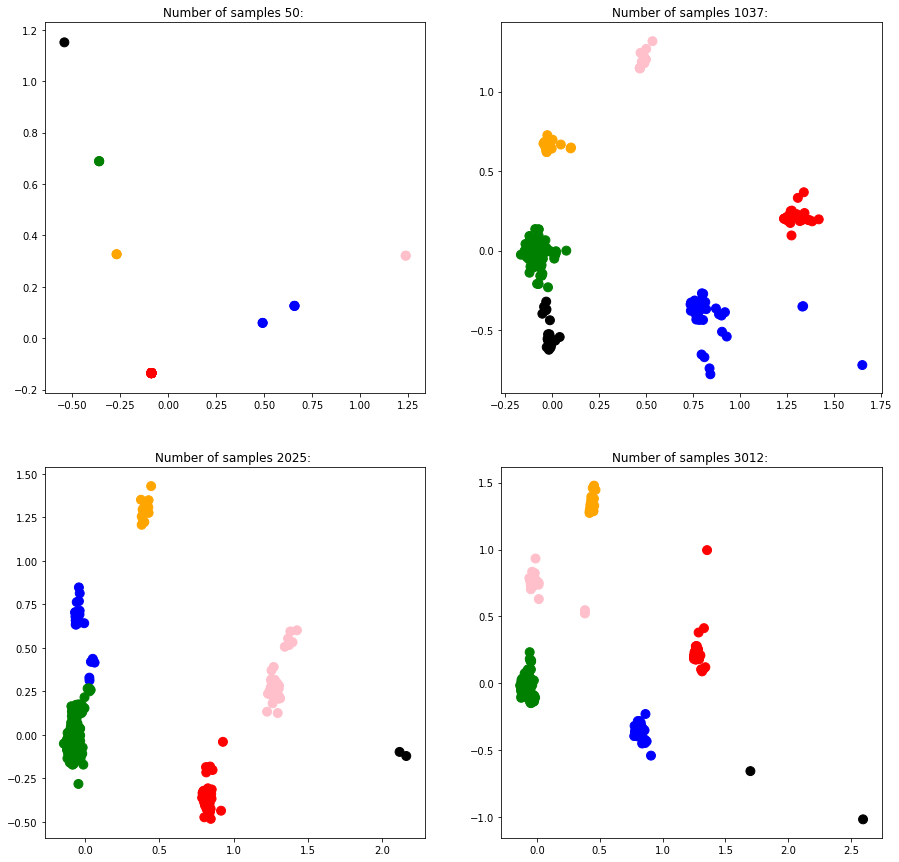

In [17]:
#using 6 clusters
sample_count = size

fig = plt.figure()
plt.figure(figsize=(15,15))
for i,f in zip(range(1, 5),sample_count):    
    plt.subplot(2, 2, i)
    plot_modelclusters(f, 6, 'cl_headline')

<Figure size 432x288 with 0 Axes>

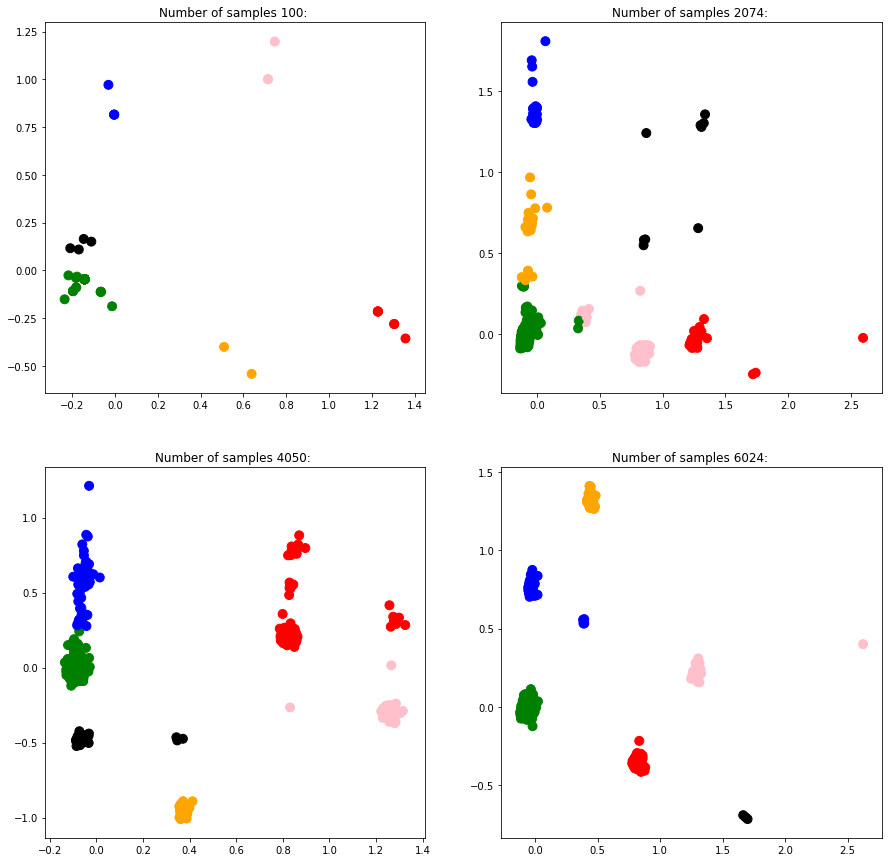

In [18]:
#choosing 7 clusters
sample_count = size*2

fig = plt.figure()
plt.figure(figsize=(15,15))
for i,f in zip(range(1, 5),sample_count):    
    plt.subplot(2, 2, i)
    plot_modelclusters(f, 6, 'cl_headline')

<Figure size 432x288 with 0 Axes>

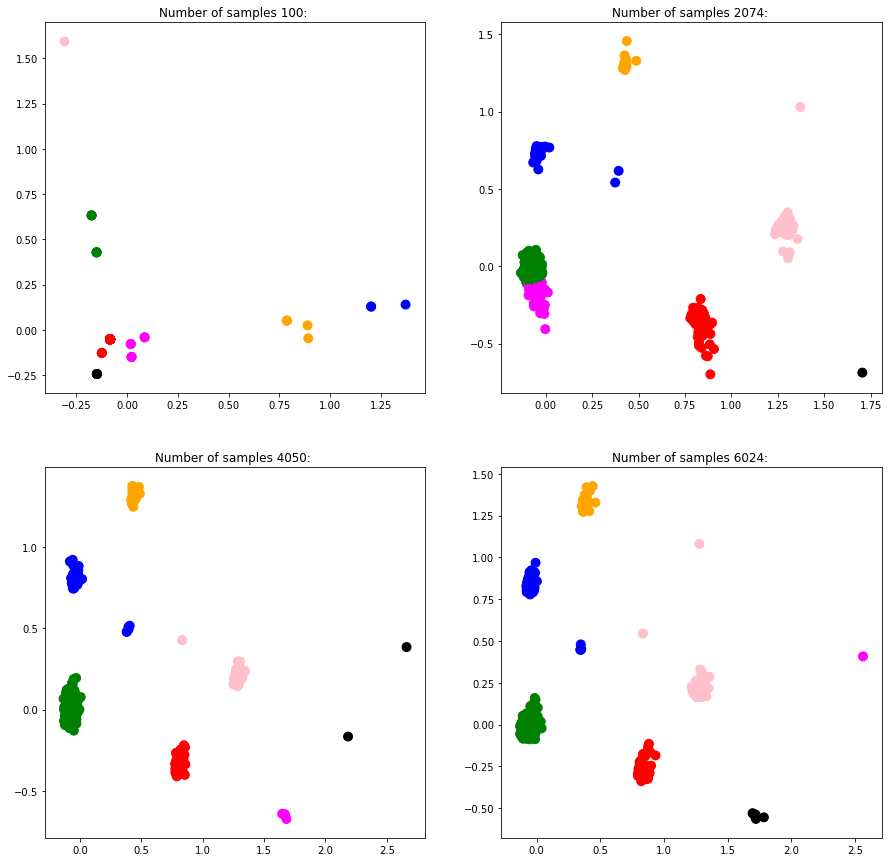

In [19]:
#doubling sample sizes on 7 clusters
sample_count = size*2

fig = plt.figure()
plt.figure(figsize=(15,15))
for i,f in zip(range(1, 5),sample_count):    
    plt.subplot(2, 2, i)
    plot_modelclusters(f, 7, 'cl_headline')

#### Visualizing the short description column

<Figure size 432x288 with 0 Axes>

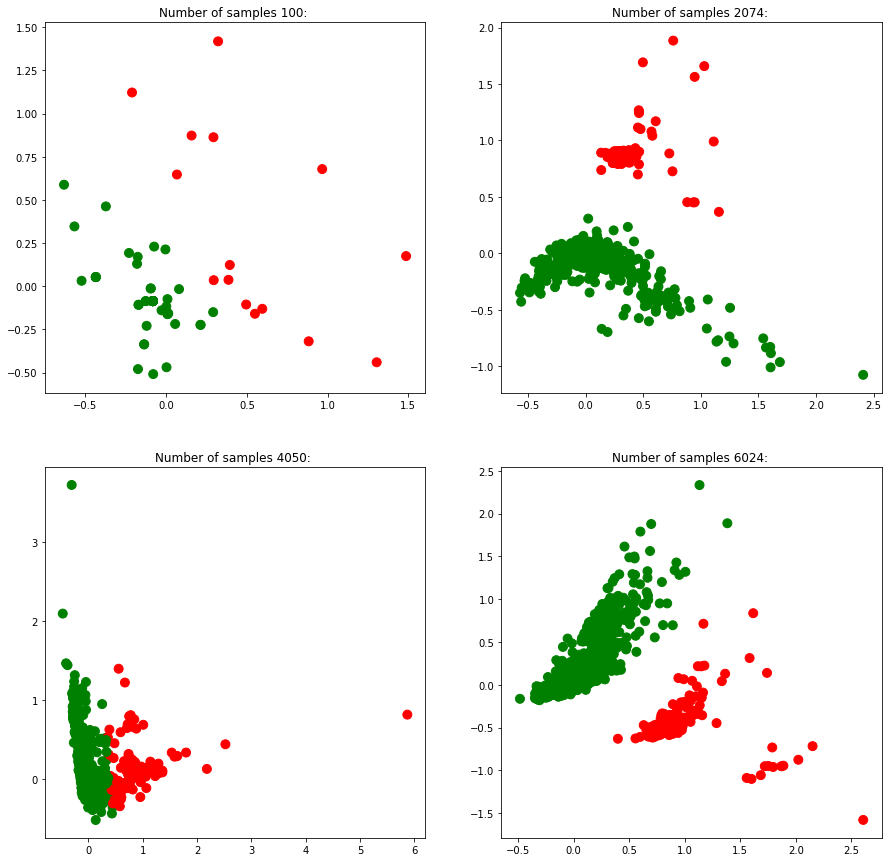

In [20]:
sample_count = size*2

fig = plt.figure()
plt.figure(figsize=(15,15))
for i,f in zip(range(1, 5),sample_count):    
    plt.subplot(2, 2, i)
    plot_modelclusters(f, 2, 'cl_short_desc')

### (iv) Analysis

Based on our clusters we observe above we can conclude the following:

_headline_
    - As the data size increases the number of well defined clusters does not necessarily increase
    - We identify that the appropriate number of clusters in this case is 6

_short descriptions_
    - Surprisingly the manner in which the data is spread out when we use the short_description column varies vastly from the headline column. 
    - Here we see that the appropriate number of clusters is simply 2

The reason for such significant differences may perhaps be on account of the differences in the text used for article titles and in the description. One can argue that the usage of category specific words in titles is vital to give a reader a sense of what the article is about in general. Whereas writers may employ general usage of words in the articles descriptions to expand on their point. 

# KNN Clustering & Classification

- K Nearest Neighbours can be employed for the purposes of clustering & classification.  

- In our case we will employ the use of the KNN algorithm as follows:
    - (i) First we will sample our data using disproportionate stratified sampling methods
    - (ii) Train and test our KNN model
    - (iii) View accuracy rates
    - (iv) Testing our model on real time data
    

### (i) Disproportionate Stratified Sampling
- We now take a crucial turn in our project and sample our data into approximately X datapoints from a dataset of 124989 articles. We do this on account of forgoing the "Memory Error" we receive on our local machines. Datasets of this size require a significant amount of computing power


- It is however important to note that we will ensure that the % of categories in the new smaller dataset will remain uniformly consistent. For instance, since we have around 30 categories, we will ensure that our training dataset has an equal percentage of news articles from each category so as to not make the model biased

_Our sampling methods comprise the following_:  
- Calculate the number of different categories in the original dataset.   

- Next we will proceed to create a dataset comprising X datapoints within which each category will be uniformly represented. Therefore our sample dataset will have an equal percentage of categories equaL to: original dataset / number of categories 

- For each category type, we randomly choose x number of rows where x equals the number of articles required for the dataset to be equivilent 

In [8]:
"""Here we write a function which will do the following: 
    Inputs: sample size desired, y column
    Outputs: for any given dataset it will return a dataset split evenly for all unique values in the y column
"""

def dis_sampling(size_desired, y_column):
    #setting the seed
    random.seed(2)

    # Number of unique values in the y column
    news_df[y_column].value_counts(dropna = True)
        
    #Here we calculate equitible proportion we want for each category 
    nums_cat = math.floor(size_desired / news_df[y_column].value_counts(dropna = True).shape[0])
#     print (size_dataset == nums_cat*news_df['category'].value_counts(dropna = True).shape[0])

    #We create a new dataframe that we will append to 
    new_df = pd.DataFrame(index=[0], columns=news_df.columns)
    new_df = new_df.fillna(0)

    #Lopping over each unique value in the y column
    for index_val, row in news_df[y_column].value_counts(dropna = True).iteritems():

        #subset a dataframe consisting of only the category selected in the loop
        a = news_df[news_df[y_column]== index_val]

        # from the subset df a we randomly choose a number of rows based on num_cat calculated above
        rands = (random.sample(list(a.index),int(nums_cat)))

        #Next we do the actual extracting of randomly chosen
        b = a.loc[rands]

        #push new category rows into the new dataframe
        new_df = pd.concat([new_df,b])
    
    #Important to note here that because of the way rounding occurs in Python, we 
    #...are left with a slightly small number of dataset than the one desired. Usually around 1% 
    #Therefore: what we're doing here is firstly dropping all empty rows if any and then further subset
    #...the existing dataset to take into account the rounding error
    new_df = new_df.iloc[1:,:].dropna(axis=0)
    new_df = new_df.iloc[1:new_df.shape[0],:]
    return new_df

# dis_sampling(1200)

### (ii) Training & Testing Our Model

In this section we conduct the following:
    - a. We train and test our model on a randomly selected datasets of varying sample sizes.
    - b. View accuract rates
    - c. We plot our accuracy rates
    
#### A)

In [85]:
"""
Here we write a function that will perform the following: 
    Inputs: column name, single letter 'p' or 'y', K as in the number of nearest neighbors
    Outputs: Accuracy rates for models trained on a given set of sample sizes
            
"""

#create empty list to append future accuracy rates
all_accu = []

#function to train and test KNN models
def train_test(column, K):
    
    #Initialize our KNN model with 5 neighbours and define the euclidean distance
    knn = KNeighborsClassifier(n_neighbors =K, 
                           p = 2)# p=2 for euclidean distance

    #-------------Subsetting our data-----------------------------

    
    #here we use the dis_sampling helper function above to create a uniform dataset of the desired sample size
    for x in new_size_c:
        temp_df = dis_sampling(int(x), 'category_num')

        #-----------------Now we count vectorize our columns-----------------------        
        
        vectorizer = CountVectorizer(min_df= 2)
        data_corpus = list(temp_df[column])

        X = vectorizer.fit_transform(data_corpus) 
        tt_df = pd.DataFrame(X.toarray(), columns =vectorizer.get_feature_names() )
        
        #----------------split up training and testing data -----------------
        
        #we choose to train 70% if any given dataset and test the model on the remainder 30% of the data
        #choosing training size
        train_size = int(temp_df.shape[0] * 0.70)
                
        #subset the dataframe into training and testing data
        tt_df['category_num']  = list(temp_df['category_num'])
        
        """
        Before we pick our training and test data, it is IMPORTANT to randomly shuffle the tt_df since the data in there
        is uniformly placed one after the other: for example:
        - the first 10 rows may be: comedy
        - next 10 rows may be: politics 
        etc so therefore doing a 80-20 split on this dataframe will only train it on a select few categories. Hence we shuffle
        """
        #next we convert our count vectorized object into an mxn dataframe where: 
        # m: number of samples
        #n : number of features or number of unique words from the data corpus after the min count threshold
        rands = (random.sample(list(tt_df.index),int(tt_df.shape[0])))
        tt_df = tt_df.loc[rands]
        
        #creating training data
        train_d = tt_df.iloc[:train_size]     

        #creating test data
        test_d = tt_df.iloc[train_size:]

            
        #fitting our model
        knn.fit(train_d.iloc[:,:-1], train_d['category_num'])
        
        #--------------testing the model------------------        
        
        #predicting on test data
        pred_list = (knn.predict(test_d.iloc[:,:-1]))
        
        #calculatong errors
        errors  = (np.array(pred_list)- np.array(test_d['category_num']))     
        
        #we can count correctly classified test data by counting the number of zeros
        accuracy =  round((len([z for z in errors if z == 0]) / len(errors))*100 ,2)                

        #appending to all_accu list for future plotting
        all_accu.append(accuracy)
        
       #finally we print our accuracy rates
        print ( 'Accuracy rate for sample size {}: '.format(x),'{} %'.format(accuracy) )         
#         plt.plot(all_accu)


#### B) 
- Now lets view the accuracy rates for a set of K values selected to be fit on the model
- We will view these accuracy rates for models trained on both columns `cl_headline` and `cl_description` 

In [89]:
#selecting our sample sizes
new_size_c = [10000]

#selecting the K values we would like to fit and test our model our models on
#k_options = [5,5,7,9,11]
k_options = [5,7]

print ('After training on column cl_headline')
print ('--------------------------------------')
for ks in k_options:    
    print ('For number of neighbors = ', ks)
    train_test('cl_headline',ks)
    print ('\n')

After training on column cl_headline
--------------------------------------
For number of neighbors =  5
Accuracy rate for sample size 10000:  6.34 %


For number of neighbors =  7
Accuracy rate for sample size 10000:  6.37 %




In [79]:
#accuracy rates for model trained on the short description column

print ('After training on column cl_short_desc')
print ('--------------------------------------')
for ks in k_options:    
    print ('For number of neighbors = ', ks)
    train_test('cl_short_desc',ks)
    print ('\n')

After training on column cl_short_desc
--------------------------------------


NameError: name 'k_options' is not defined

### (iii) Plotting Accuracy Rates 

Here we will visualize the average accuracy rate for each K selected

Text(0,0.5,'Average Accuracy %')

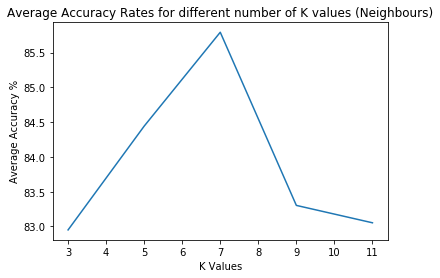

In [40]:
#selecting our sample sizes
new_size_c = size[1:]

#selecting the K values we would like to fit and test our model our models on
k_options = [3,5,7,9,11]

plt.plot( k_options,np.mean(np.array(all_accu[:20]).reshape(-1, 4), axis=1))
plt.title('Average Accuracy Rates for different number of K values (Neighbours)')
plt.xlabel('K Values')
plt.ylabel('Average Accuracy %')

Based on the output above, we can arrive at the following conclusions: 
    - There is no direct correlation with the accuracy rates and the number of neighbors selected
    - Based on our models we can see that the accuracy rates peak at around 7 K values selected as number of neighbors
    - The accuracy rates can perhaps be further improved if we had more data to sample from and changed more parameters

## Project Summary

In summary the preprocessing functions and the trained models in this project will allow our stakeholders to implement the following:

- Detailed analysis of any given dataset to gain insights into its contents and overall interests
- Access to collect numerical data on a dataset such as this, for instance the number of like or comments on a news articles, will also allow our stakeholders to perform regression analysis and determine what kind of articles will get more attention for a given target audience


### Benefits

Our model will allow for any text to be grouped with other text, perhaps not even of the same medium! It forgoes the notion of genre and shows which text data are similar to whichever other text data. This has a multitude of uses to many industries, such as publishers or even advertisers.

### Future Adaptations

There are a few natural directions that this study could go in the future. First and foremost, this study should be repeated with more data. Furthermore, entire articles, books, magizines, and other print materials should be tested in the above manner. It would be interesting to see if books and magizines also follow clustering patterns, and whether they correlate to what their actual "genre" is assumed to be. 

There should also be more testing data. While it is demonstrative of our point to write fake headlines and descriptions to test, it would be interesting to see how our KNN predictor will perform on real testing data. 

Lastly, small modifications could be made in an attempt to find some better accuracy pertaining to the original labels. For instance, there are a multitude of other ways the `min_df` parameter could be calculated; the optimal number of clusters could be found using more than just visual observation and intuition; and finally, it is likely that there are other sampling techniques that would also be appropriate in our situation.



# Project Report

This project found that there are some distinct clusters of news articles, the number of which increases with the sample size. This may seem intuitively obvioius, but it also suggests that articles are written encompassing a multitude of topics that are constantly evolving with our society. For example, we may see some articles about President Donald Trump that some might classify as politics while others may classify it as entertainment or world news. 

While at first, one may speculate that the resulting clusters from this analysis should mimick the clusters of the prelabelled data observations, that is entirely not the case. The original data shows 30 distinct labels, but the clustering analyses show about six to seven clusters as the optimal number of clusters. This was concluded in both the **Hierarchical Clustering** and **K Means** sections. 

It may be that the massive difference between the initial classifications of each article and the clusters resulting from this analysis can be attributed to the notion that the initial labels are not entirely distinct (one article might be about both politics and crime, for example). It may also happen that some initial classifications, while seemingly distinct, are in fact entire subsets (or even partial subsets) of other classifications. In such a case, prelabelled clusters may be clustered together, which would decrease the number of clusters.

Taking into account these phenomena, it is feasible that the results of the analysis hold some correlation to the original classifications. This is shown in the multiple predictions using the KNN technique. Each label that was predicted was one of the original 30 labels. Simple visual observation will demonstrate that the predicted labels seem to pertain to the content of the article given a large enough sample size.

## Flask Deploy

In [90]:
# Model deploy in Flask

#Initialize our KNN model with 5 neighbours and define the euclidean distance
knn = KNeighborsClassifier(n_neighbors =7, 
                   p = 2)# p=2 for euclidean distance

temp_df = dis_sampling(12000, 'category_num')      

vectorizer = CountVectorizer(min_df= 5)
data_corpus = list(temp_df['cl_headline'])

X = vectorizer.fit_transform(data_corpus) 
tt_df = pd.DataFrame(X.toarray(), columns =vectorizer.get_feature_names() )

train_size = int(temp_df.shape[0] * 0.95)

#subset the dataframe into training and testing data
tt_df['category_num']  = list(temp_df['category_num'])

rands = (random.sample(list(tt_df.index),int(tt_df.shape[0])))
tt_df = tt_df.loc[rands]

#creating training data
train_d = tt_df.iloc[:train_size]     

#creating test data
test_d = tt_df.iloc[train_size:]

#fitting our model
knn.fit(train_d.iloc[:,:-1], train_d['category_num'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [96]:
new_val = vectorizer.transform(['aaron abandoned', 'aaron']) 

print ('New value: ', new_val.toarray())
new_val.toarray().shape
knn.predict(new_val.toarray())

New value:  [[1 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


array([0, 0], dtype=int64)